In [48]:
import cooler
import bioframe
import cooltools
import os
import pandas as pd
import json
from typing import Dict, Any, List
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
assert os.environ['CONDA_DEFAULT_ENV'] == "cultures_hic"
load_dotenv()

True

In [10]:
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Helvetica'
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)

In [11]:
path_to_maps = os.getenv('PATH_TO_MAPS')
path_to_tads = os.getenv('PATH_TO_SAVE_TAD_BORDERS')
path_to_mapping = os.getenv('PATH_TO_MAIN_MAPS_MAPPING')
path_to_reduced_insulation_tables = os.getenv('PATH_TO_REDUCED_IS_TABLES')
path_to_save_pca_data = os.getenv('PATH_TO_SAVE_TAD_PCA_DATA')
path_to_tads_clusters = os.getenv('PATH_TO_TADS_CLUSTERS')
path_to_save_visualizations = os.getenv('PATH_TO_TADS_VISUALIZATIONS')
path_to_maps_expected = os.getenv('PATH_TO_EXPECTED_MAPS')

## 1. Prepare expected maps 

In [22]:
def get_hg38_arms():
    """
    Fetches human genome version hg38 chromosome arms excluding 'chrM'.
    
    Returns:
        pd.DataFrame: A DataFrame containing chromosome arms for hg38 without 'chrM'.
    """
    try:
        hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
        hg38_cens = bioframe.fetch_centromeres('hg38')
        hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
        # Exclude mitochondrial chromosome 'chrM' and reset index
        return hg38_arms[hg38_arms['chrom'] != 'chrM'].reset_index(drop=True)
    except Exception as e:
        print(f"An error occurred while fetching hg38 arms: {e}")
        raise

def get_source2map(merged_bedpe_clf_2_filtered, maps2loops):
    """
    Maps each unique source in `merged_bedpe_clf_2_filtered` to its corresponding loop from `maps2loops`.
    
    Returns:
        dict: A dictionary mapping sources to their corresponding map loop.
    """
    source2map = {}
    try:
        for source in merged_bedpe_clf_2_filtered['source'].unique():
            name = source.split("_sampled_dots_final_")[0]
            maps = [k for k, v in maps2loops.items() if name in v]
            if len(maps) != 1:
                raise ValueError(f"Expected exactly one map for {source}, found {len(maps)}.")
            source2map[source] = maps[0].split('/')[-1]
        return source2map
    except KeyError as e:
        print(f"Key error: {e}")
        raise
    except ValueError as e:
        print(f"Value error: {e}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

def get_expected_for_maps(clr, map_prefix, hg38_arms, path_to_maps_expected, nproc=16):
    expected_per_chrArm = cooltools.expected_cis(clr, view_df=hg38_arms, nproc=nproc)
    expected_per_chrArm.to_pickle(f'{path_to_maps_expected}/{map_prefix}_perChrArm.pickle')
    return expected_per_chrArm

def load_and_prepare_data(path_to_tads_clusters, path_to_mapping, path_to_maps, path_to_maps_expected, hg38_arms):
    tads = pd.read_pickle(f'{path_to_tads_clusters}/Post-mortem neurons_vs_iPSC-derived neurons_clusters_merged_df.pickle') # results from 2.2 notebook

    tads_ipsc_derived = tads[tads.Group == "iPSC-derived neurons"].iloc[:, :3].drop_duplicates()
    tads_pm = tads[tads.Group != "iPSC-derived neurons"].iloc[:, :3].drop_duplicates()
    borders_lists_all = {"iPSC-derived neurons": tads_ipsc_derived, 'Post-mortem neurons': tads_pm}
    
    shortname2group = dict(tads[['short_name_for_plot', 'Group']].values)
    mapping = pd.read_feather(f'{path_to_mapping}/main_files_mapping.feather')
    maps_stored = {}
    
    sources = tads.source.unique()
    for source in sources:
        maps_stored[source] = {}
        matching_maps = mapping.loc[mapping.sample_init == source, 'sample_map']
        if len(matching_maps) != 1:
            raise ValueError(f"Expected one matching map for source {source}, found {len(matching_maps)}")
        map_name = matching_maps.iloc[0]
        print(f"Processing source: {source}, map: {map_name}")
        map_prefix = map_name.split('.mcool', 0)[0]
        
        clr = cooler.Cooler(f'{path_to_maps}/{map_name}::/resolutions/15000')
        maps_stored[source]['clr'] = clr
        maps_stored[source]['expected'] = get_expected_for_maps(clr, map_prefix, hg38_arms, path_to_maps_expected, nproc=16)

    return maps_stored, borders_lists_all, shortname2group

In [23]:
maps_stored, borders_lists_all, shortname2group = load_and_prepare_data(
    path_to_tads_clusters,
    path_to_mapping,
    path_to_maps,
    path_to_maps_expected,
    hg38_arms=get_hg38_arms()
)

Processing source: Ballerino2022_iPSC_NeuNplus, map: Ballerino2022_iPSC_NeuNplus.sampled_exact.mcool
Processing source: Heffel_adult, map: Heffel_adult.3056_cells.5kb.drop_diag.5kb.sampled_exact.mcool
Processing source: Hu2021_NeuNplus, map: Hu2021_NeuNplus.sampled_exact.mcool
Processing source: Li2022_iPSC_NeuNplus, map: Li2022_iPSC_NeuNplus.sampled_exact.mcool
Processing source: Our_data_iPSC_NeuNplus, map: Our_data_iPSC_NeuNplus.drop_diag.5kb.mcool.sampled_exact.mcool
Processing source: Pletenev2024_NeuNplus, map: Pletenev2024_NeuNplus.sampled_exact.mcool
Processing source: Rahman2023_NeuNplus, map: Rahman2023_NeuNplus.sampled_exact.mcool
Processing source: Rahman2023_iPSC_NeuNplus, map: Rahman2023_iPSC_NeuNplus_CRISPRi_Scrambled_A_DpnII-HinfI.sampled_exact.mcool
Processing source: Rajarajan_iPSC_NeuNplus, map: Rajarajan_iPSC_NeuNplus.sampled_exact.mcool
Processing source: Tian2023_NeuNplus, map: Tian2023_NeuNplus.EN_IN.29_42_58_years.2000_cells.sampled_exact.mcool
Processing source

## 2. Calculate the pileups

In [51]:
from coolpuppy import coolpup

DEFAULT_FACTOR = 20
DEFAULT_RESOLUTION = 15_000
NUM_PROCESSORS = 10

In [62]:
def create_matrix_calculated(source, merged_clusters, use_expected, factor=DEFAULT_FACTOR, resolution=DEFAULT_RESOLUTION):
    """
    Create a matrix using either expected data or not from a given source.

    Parameters:
    - source: The data source identifier.
    - merged_clusters: Data frame of merged clusters.
    - use_expected: Boolean to determine whether to use expected data.
    - factor: Multiplier for the resolution (default is 20).
    - resolution: Resolution of the matrix (default is 15,000).

    Returns:
    - mtx: The mean matrix.
    - stack: The stack of pileup matrices.
    """
    flank = factor * resolution
    parameters = {
        'view_df': hg38_arms,
        'flank': flank,
        'nproc': NUM_PROCESSORS
    }
    
    if use_expected:
        parameters['expected_df'] = maps_stored[source]['expected']
        parameters['min_diag'] = 1

    stack = cooltools.pileup(maps_stored[source]['clr'], merged_clusters, **parameters)
    mtx = np.nanmean(stack, axis=0)

    return mtx, stack

def create_matrix_calculated2(source, merged_clusters, factor=DEFAULT_FACTOR, resolution=DEFAULT_RESOLUTION):
    """
    Create a matrix from given clusters without using expected data.

    Parameters and returns same as create_matrix_calculated
    """
    flank = factor * resolution
    cc = coolpup.CoordCreator(
        merged_clusters,
        resolution=resolution,
        flank=flank,
        features_format='bed',
        local=True,
        rescale_flank=1
    )
    pu = coolpup.PileUpper(
        maps_stored[source]['clr'],
        cc,
        expected=maps_stored[source]['expected'],
        view_df=hg38_arms,
        ignore_diags=0,
        rescale_size=99,
        rescale=True
    )
    pup = pu.pileupsWithControl(nproc=NUM_PROCESSORS)
    
    return pup.data[0]

def create_tads_borders_data(tads, source2group, factor_selected, type_calculation='median', use_expected=True):
    """
    Create TADs borders data for each group and calculate statistics.
    
    Parameters:
    - tads: Data frame of TADs.
    - source2group: Mapping of sources to groups.
    - factor_selected: Multiplier for the resolution.
    - type_calculation: The statistic type to calculate ('median' or 'mean').
    - use_expected: Boolean to determine whether to use expected data.

    Returns:
    - results: Dictionary of calculated matrices for each group.
    - mean_results: Dictionary of mean or median results for each group.
    """
    results = {}
    mean_results = {}

    for group in tads.Group.unique():
        results[group] = {}
        mean_results_temp = []

        group_sources = [i for i, k in source2group.items() if k == group]
        for source in group_sources:
            print(f"Processing source: {source}")
            df = tads[tads.source == source]
            mtx, stack = create_matrix_calculated(source, df, use_expected, factor=factor_selected)
            results[group][source] = {"mtx": mtx, "stack": stack}
            mean_results_temp.append(mtx)

        mean_results[group] = np.nanmedian(mean_results_temp, axis=0) if type_calculation == "median" else np.nanmean(mean_results_temp, axis=0)

    return results, mean_results

In [63]:
def plot_tads_borders(data, factor, vmax=1, use_min_max=True, resolution = 15000):
    """
    Plots TADs borders using a heatmap.

    Parameters:
    - data: 2D numpy array
        The data to be plotted, typically a matrix of observed/expected values.
    - factor: int
        The factor by which the resolution is multiplied to determine the flank size.
    - vmax: float, optional, default=1
        The maximum value for the color scale.
    - use_min_max: bool, optional, default=True
        If True, sets the color scale to symmetric around zero.

    Returns:
    - None
    """
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array.")
    if data.ndim != 2:
        raise ValueError("Data must be a 2D array.")
    if not isinstance(factor, int) or factor <= 0:
        raise ValueError("Factor must be a positive integer.")
    if not isinstance(vmax, (int, float)) or vmax <= 0:
        raise ValueError("vmax must be a positive number.")
    if not isinstance(use_min_max, bool):
        raise TypeError("use_min_max must be a boolean.")
    flank = factor * resolution

    try:
        log_data = np.log2(data)
    except ValueError as e:
        raise ValueError("Data contains non-positive values, cannot compute log2.") from e

    plt.figure(figsize=(8, 6))
    if use_min_max:
        plt.imshow(
            log_data,
            vmax=vmax,
            vmin=-vmax,
            cmap='coolwarm',
            interpolation='none'
        )
    else:
        plt.imshow(
            log_data,
            cmap='coolwarm',
            interpolation='none'
        )

    plt.colorbar(label='log2 mean obs/exp')
    ticks_pixels = np.linspace(0, flank * 2 // resolution, 5)
    ticks_kbp = ((ticks_pixels - ticks_pixels[-1] / 2) * resolution // 1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    plt.title('TADs Borders Heatmap')
    plt.tight_layout()
    plt.show()

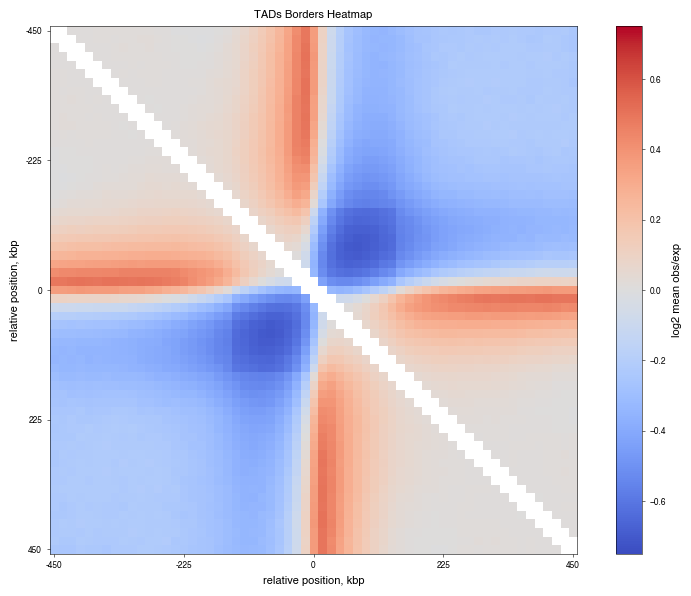

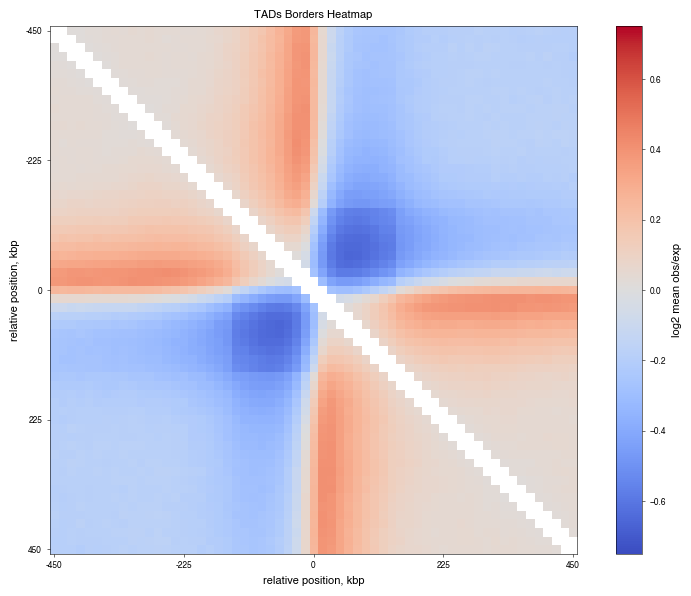

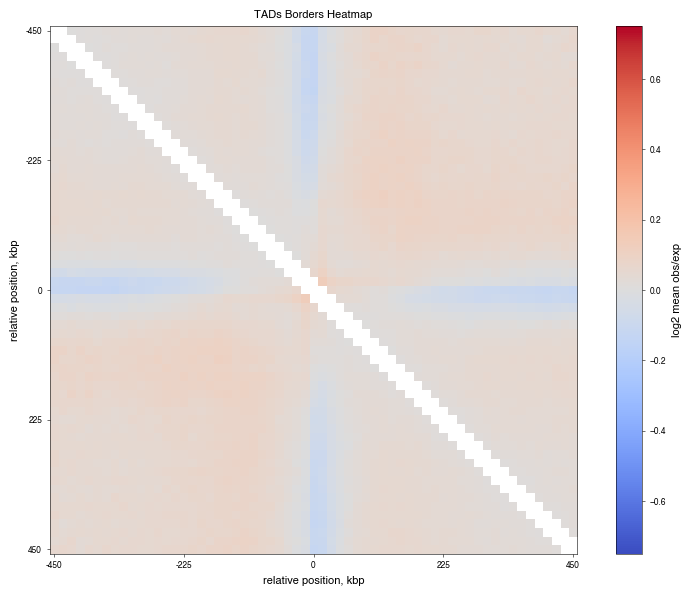

In [65]:
source2group = dict(tads[["source", "Group"]].values)
factor = 30
results_30, mean_results_30 = create_tads_borders_data(tads, source2group, factor, maps_stored)                                   
plot_tads_borders(mean_results_30["iPSC-derived neurons"], factor, vmax=0.75)
plot_tads_borders(mean_results_30["Post-mortem neurons"], factor, vmax=0.75)
plot_tads_borders(mean_results_30["Post-mortem neurons"]/mean_results_30["iPSC-derived neurons"], factor, vmax=0.75)

Processing source: Ballerino2022_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Li2022_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Our_data_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Rahman2023_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Rajarajan_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Wu2021_iPSC_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Zaghi2023_iPSC_NeuNplus
Processing source: Heffel_adult


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)
/tmp/ipykernel_1704600/1988489758.py:90: RuntimeWarning: Mean of empty slice
  mean_results[group] = np.nanmedian(mean_results_temp, axis=0) if type_calculation == "median" else np.nanmean(mean_results_temp, axis=0)
/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Hu2021_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Pletenev2024_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Rahman2023_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)


Processing source: Tian2023_NeuNplus


/tmp/ipykernel_1704600/1988489758.py:28: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)
/tmp/ipykernel_1704600/1988489758.py:90: RuntimeWarning: Mean of empty slice
  mean_results[group] = np.nanmedian(mean_results_temp, axis=0) if type_calculation == "median" else np.nanmean(mean_results_temp, axis=0)


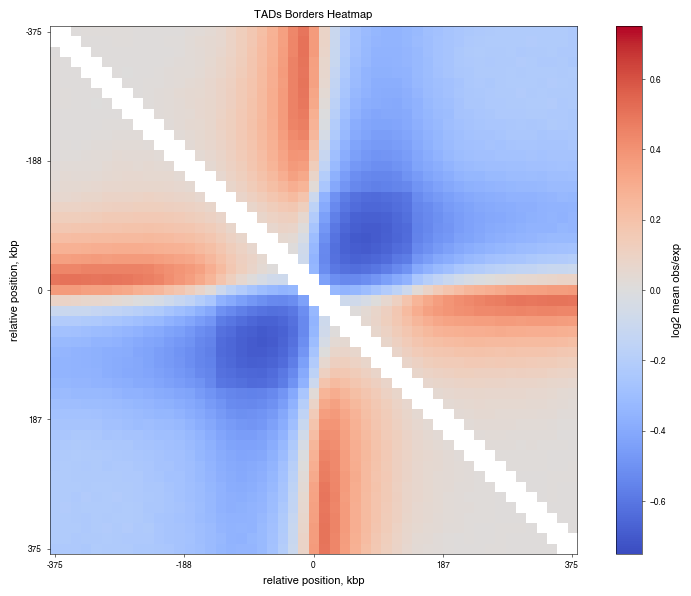

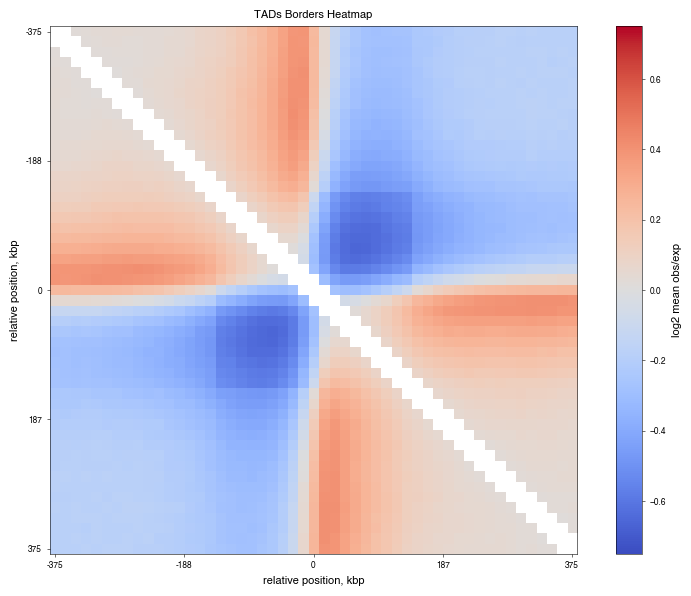

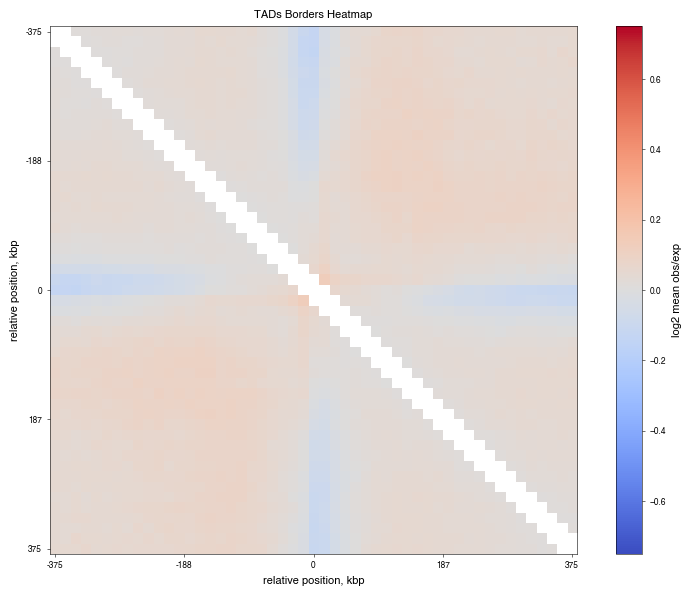

In [68]:
factor = 25
results_25, mean_results_25 = create_tads_borders_data(tads, source2group, factor, maps_stored)
plot_tads_borders(mean_results_25["iPSC-derived neurons"], factor, vmax=0.75)
plot_tads_borders(mean_results_25["Post-mortem neurons"], factor, vmax=0.75)
plot_tads_borders(mean_results_25["Post-mortem neurons"]/mean_results_25["iPSC-derived neurons"], factor, vmax=0.75)

## 3. Separate parts of the plot

In [95]:
from matplotlib.patches import Rectangle, Polygon
import scipy.stats as stats
import seaborn as sns

In [81]:
def generate_indexes(x_start, y_start, width, height):
    x_indexes = []
    y_indexes = []
    for y in range(y_start, y_start + height):
        for x in range(x_start, x_start + width):
            x_indexes.append(x)
            y_indexes.append(y)
    return x_indexes, y_indexes

def generate_stripe_indexes():
    get_x_indexes2 = []
    get_y_indexes2 = []
    x_start = 2
    y_start = 0
    x_current = x_start
    y_current = y_start
    n=19
    for i in range(30):
        while x_current < n:
            get_x_indexes2.append(x_current)
            get_y_indexes2.append(y_current)
            x_current+=1
        y_current+=1
        x_start+=1
        x_current = x_start
    return get_x_indexes2, get_y_indexes2
    
def extract_values(results, x_indexes, y_indexes, neuron_type):
    values = []
    for x, y in zip(x_indexes, y_indexes):
        for key in results[neuron_type]:
            values.append(results[neuron_type][key]['mtx'][x][y])
    return values

def create_dataframe(values, group_name):
    df = pd.DataFrame(values, columns=["value"])
    df['group'] = group_name
    return df

def get_tads_parts(results_25):
    # Generate indexes for stripe part
    stripe_x_indexes, stripe_y_indexes = generate_stripe_indexes()

    # Generate indexes for internal part
    internal_x_indexes, internal_y_indexes = generate_indexes(x_start=25, y_start=31, width=4, height=20)

    # Extract values for stripe part
    stripe_part_ipsc = extract_values(results_25, stripe_x_indexes, stripe_y_indexes, "iPSC-derived neurons")
    stripe_part_pm = extract_values(results_25, stripe_x_indexes, stripe_y_indexes, "Post-mortem neurons")

    # Extract values for internal part
    internal_part_ipsc = extract_values(results_25, internal_x_indexes, internal_y_indexes, "iPSC-derived neurons")
    internal_part_pm = extract_values(results_25, internal_x_indexes, internal_y_indexes, "Post-mortem neurons")

    stripe_df = pd.concat([
        create_dataframe(stripe_part_ipsc, 'iPSC-derived neurons'),
        create_dataframe(stripe_part_pm, 'Post-mortem neurons')
    ])

    internal_df = pd.concat([
        create_dataframe(internal_part_ipsc, 'iPSC-derived neurons'),
        create_dataframe(internal_part_pm, 'Post-mortem neurons')
    ])

    return stripe_df, internal_df, stripe_x_indexes, stripe_y_indexes, internal_x_indexes, internal_y_indexes

def plot_tad_data(data, factor=25, use_min_max=True, vmax=0.7, resolution=15000, 
                     get_x_indexes2=None, get_y_indexes2=None, 
                     get_x_line_indexes2=None, get_y_line_indexes2=None):
    """
    Plots the TAD with specified parameters.

    Parameters:
    - data: 2D numpy array of neuron data.
    - factor: Multiplier for resolution to determine flank size.
    - use_min_max: Boolean to determine if min/max scaling should be used.
    - vmax: Max value for color scaling.
    - resolution: Resolution of the data.
    - get_x_indexes2, get_y_indexes2: Lists of x and y indexes for rectangles.
    - get_x_line_indexes2, get_y_line_indexes2: Lists of x and y indexes for line rectangles.
    """
    if data is None or not isinstance(data, np.ndarray):
        raise ValueError("Data must be a non-empty numpy array.")

    if get_x_indexes2 is None or get_y_indexes2 is None:
        get_x_indexes2, get_y_indexes2 = [], []

    if get_x_line_indexes2 is None or get_y_line_indexes2 is None:
        get_x_line_indexes2, get_y_line_indexes2 = [], []

    plt.figure(figsize=(4, 4))
    flank = factor * resolution

    # Determine color scaling
    if use_min_max:
        plt.imshow(
            np.log2(data),
            vmax=vmax,
            vmin=-vmax,
            cmap='coolwarm',
            interpolation='none'
        )
    else:
        plt.imshow(
            np.log2(data),
            cmap='coolwarm',
            interpolation='none'
        )

    plt.colorbar(label='log2 mean obs/exp')

    # Set ticks and labels
    ticks_pixels = np.linspace(0, flank * 2 // resolution, 5)
    ticks_kbp = ((ticks_pixels - ticks_pixels[-1] / 2) * resolution // 1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')

    # Add rectangles
    for x, y in zip(get_x_indexes2, get_y_indexes2):
        plt.gca().add_patch(Rectangle((x, y), 1, 1, ec='grey', fc='none', lw=0.4))

    for x, y in zip(get_x_line_indexes2, get_y_line_indexes2):
        plt.gca().add_patch(Rectangle((x, y), 1, 1, ec='grey', fc='none', lw=0.4))

    plt.show()
    


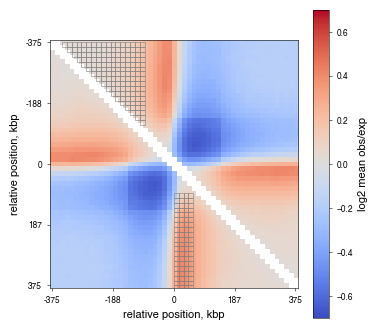

In [91]:
stripe_df, internal_df, stripe_x_indexes, stripe_y_indexes, internal_x_indexes, internal_y_indexes = get_tads_parts(results_25)
plot_tad_data(mean_results_25["Post-mortem neurons"], get_x_indexes2=stripe_x_indexes, get_y_indexes2=stripe_y_indexes, 
                     get_x_line_indexes2=internal_x_indexes, get_y_line_indexes2=internal_y_indexes)

In [103]:
def statistical_analysis(df, group_col, value_col, group_a, group_b):
    """
    Perform Mann-Whitney U and T-test between two groups in the given dataframe.
    
    Parameters:
        df (pd.DataFrame): The data containing groups and values.
        group_col (str): The name of the column containing group labels.
        value_col (str): The name of the column containing values.
        group_a (str): The label for the first group.
        group_b (str): The label for the second group.

    Returns:
        dict: A dictionary containing the results of the statistical tests.
    """
    group1 = df[df[group_col] == group_a][value_col]
    group2 = df[df[group_col] == group_b][value_col]
    
    res = {}
    res['u_statistic'], res['mannwhitneyu_p_value'] = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    res['t_statistic'], res['ttest_p_value'] = stats.ttest_ind(group1, group2, equal_var=False)
    
    return res


def plot_results(df, group_col, value_col, save_name, ylim=(0.9, 1.52)):
    """
    Plot a boxplot of the given dataframe.

    Parameters:
        df (pd.DataFrame): The data to plot.
        group_col (str): The name of the column containing group labels.
        value_col (str): The name of the column containing values.
        save_name (str): The name of the file to save the plot.
        ylim (tuple): Y-axis limits.

    Returns:
        None
    """
    sns.set_style("ticks")
    palette = {
        'iPSC-derived neurons': '#469433',
        'Stem-like cells': 'dimgrey',
        'Fetal neurons': '#9c2725',
        'Post-mortem neurons': '#034e91',
        'Post-mortem non-neurons': '#764e3f',
        'iPSC-derived glia': '#ffa500',
        "Primary neurons": "#77658c"
    }

    plt.figure(figsize=(2, 3))
    sns.boxplot(
        x=group_col, y=value_col, data=df, width=0.4,
        showmeans=True, hue=group_col,
        boxprops=dict(linewidth=0.4),
        whiskerprops=dict(linewidth=0.4),
        capprops=dict(linewidth=0.4),
        medianprops=dict(linewidth=0.4),
        palette=palette,
        meanprops={
            "marker": "o",
            "markeredgecolor": "white",
            "markerfacecolor": "white",
            "markersize": "3"
        },
        showfliers=False
    )
    plt.ylim(ylim)
    plt.legend(bbox_to_anchor=(2.4, 1.05))
    plt.savefig(f"{save_name}.pdf", bbox_inches='tight', format='pdf')


def analyze_tads(stripe_df, internal_df, path_to_save_visualizations):
    stripe_stats = statistical_analysis(stripe_df, 'group', 'value', 'Post-mortem neurons', 'iPSC-derived neurons')
    print('## Stripe regions')
    print(f"Stripe Data - U statistic: {stripe_stats['u_statistic']}, P-value: {stripe_stats['mannwhitneyu_p_value']}")
    print(f"Stripe Data - T statistic: {stripe_stats['t_statistic']}, P-value: {stripe_stats['ttest_p_value']}")

    plot_results(
        df=stripe_df,
        group_col='group',
        value_col='value',
        save_name=f"{path_to_save_visualizations}/stripe_part_of_tads"
    )
    plt.show()
    print('## Internal regions')
    internal_stats = statistical_analysis(internal_df, 'group', 'value', 'Post-mortem neurons', 'iPSC-derived neurons')
    print(f"Internal Data - U statistic: {internal_stats['u_statistic']}, P-value: {internal_stats['mannwhitneyu_p_value']}")
    print(f"Internal Data - T statistic: {internal_stats['t_statistic']}, P-value: {internal_stats['ttest_p_value']}")

    plot_results(
        df=internal_df,
        group_col='group',
        value_col='value',
        save_name=f"{path_to_save_visualizations}/internal_part_of_tads"
    )
    plt.show()

## Stripe regions
Stripe Data - U statistic: 566546.0, P-value: 1.3775078922568903e-44
Stripe Data - T statistic: 13.17666348108456, P-value: 1.3289707325160599e-37


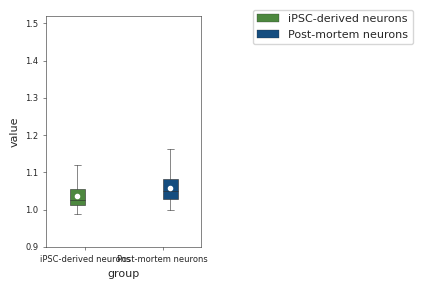

## Internal regions
Internal Data - U statistic: 94491.0, P-value: 3.567489655874874e-05
Internal Data - T statistic: -3.6913794284476373, P-value: 0.0002358567037221362


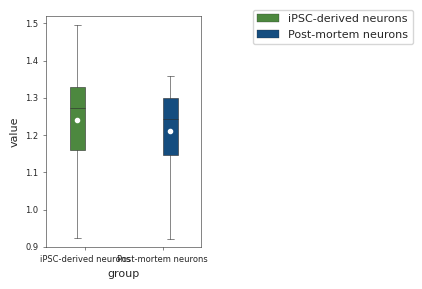

In [104]:
analyze_tads(stripe_df, internal_df, path_to_save_visualizations)